In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

import ray
from ray import tune
from ray.air import CheckpointConfig, RunConfig
from ray.air.integrations.wandb import WandbLoggerCallback
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.util.joblib import register_ray

import optuna

import wandb

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    balanced_accuracy_score,
)

In [ ]:
IS_RUNNING_LOCALLY = False

In [ ]:
if IS_RUNNING_LOCALLY:
    DATASET_PATH = './BindingDB_cleaned_with_mols_&_fingerprints_&_embeddings_LOCAL.pkl'
else:
    DATASET_PATH = './BindingDB_cleaned_with_mols_&_fingerprints_&_embeddings.pkl'

In [44]:
INTERACTION_THRESHOLD = 1.8 if IS_RUNNING_LOCALLY else 10
FINGERPRINT_SIZE = 256

HYPERPARAMETER_TUNING_DATASET_SIZE = 0.1

TEST_SIZE = 0.2
VALID_SIZE = 0.2
SEED = 42

N_SPLITS = 3

In [45]:
df = pd.read_pickle(DATASET_PATH)

if IS_RUNNING_LOCALLY:
    df = df.sample(1_000, random_state=SEED)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 2691981 to 38516
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Monomer ID           1000 non-null   float64
 1   Target ID            1000 non-null   float64
 2   Target type          1000 non-null   object 
 3   Ki (nM)              1000 non-null   float64
 4   Drug SMILES          1000 non-null   object 
 5   Target Sequence      1000 non-null   object 
 6   Mols                 1000 non-null   object 
 7   ECPF                 1000 non-null   object 
 8   Topological Torsion  1000 non-null   object 
 9   Protein Embedding    1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 85.9+ KB


In [46]:
df["Interaction"] = (df["Ki (nM)"] <= INTERACTION_THRESHOLD).astype(int)

df["Embeddings"] = df.apply(
    lambda x: np.concatenate(
        (
            x["ECPF"].flatten(),
            x["Topological Torsion"].flatten(),
            x["Protein Embedding"],
        )
    ),
    axis=1,
)

In [47]:
X = np.array(list(df["Embeddings"].to_numpy()))
y = df["Interaction"].to_numpy()

In [48]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=y,
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=VALID_SIZE, random_state=SEED
)

print(
    f"Train set: {X_train.shape}, {y_train.shape}\n"
    f"Validation set: {X_valid.shape}, {y_valid.shape}\n"
    f"Test set: {X_test.shape}, {y_test.shape}"
)

Train set: (640, 832), (640,)
Validation set: (160, 832), (160,)
Test set: (200, 832), (200,)


Based on the amount of records in the datasets, for hyperparameter tuning we will use only 10% of it

In [49]:
if IS_RUNNING_LOCALLY:
    X_hyperparameter_tuning = X
    y_hyperparameter_tuning = y
else:
    X_hyperparameter_tuning, _, y_hyperparameter_tuning, _ = train_test_split(
        X,
        y,
        train_size=HYPERPARAMETER_TUNING_DATASET_SIZE,
        random_state=SEED,
        stratify=y,
    )

print(
    f"Dataset for hyperparameter tuning: {X_hyperparameter_tuning.shape}, {y_hyperparameter_tuning.shape}"
)

Dataset for hyperparameter tuning: (1000, 832), (1000,)


In [ ]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class LGBMTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = True  # LightGBM supports eval_set

    fixed_params = {
        "random_state": SEED,
        "n_jobs": -1,
        "verbose": -1,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, LGBMTrainable.fixed_params["random_state"])

        self.model = LGBMClassifier(**config, **LGBMTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if LGBMTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        self.model.booster_.save_model(checkpoint_path)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        self.model._Booster = lgb.Booster(model_file=checkpoint["path"])


In [51]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("n_estimators", 10, 200)
    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    trial.suggest_int("num_leaves", 20, 100)
    trial.suggest_int("max_depth", 3, 10)
    trial.suggest_int("min_child_samples", 5, 20)
    trial.suggest_float("subsample", 0.5, 1.0)
    trial.suggest_float("colsample_bytree", 0.5, 1.0)
    trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)

    return {}

In [52]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-01 09:48:17,669	INFO worker.py:1888 -- Started a local Ray instance.


In [53]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = LGBMTrainable
STUDY_NAME = "LGBM_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "roc_auc"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [54]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        # WandbLoggerCallback(project=study_name),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-01 09:49:27,214	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/milosz/ray_results/LGBM_Optimization' in 0.0082s.
2025-06-01 09:49:27,218	INFO tune.py:1041 -- Total run time: 65.76 seconds (65.73 seconds for the tuning loop).


Best hyperparameters found: {'n_estimators': 68, 'learning_rate': 0.0002185837053086611, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.7475884550556351, 'colsample_bytree': 0.5171942605576092, 'reg_alpha': 1.5271567592511939, 'reg_lambda': 2.133142332373e-06}
Best roc_auc found: 0.6965


In [ ]:
lgbm_best_params = {**best_params, **LGBMTrainable.fixed_params}
lgbm_clf = LGBMClassifier(**lgbm_best_params)
lgbm_clf.fit(
    X_train,
    y_train,
    **({"eval_set": [(X_valid, y_valid)]} if LGBMTrainable.SHOULD_SET_EVAL_SET else {}),
)

y_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

/Users/milosz/SemestrVIII/LSC/proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [56]:
lgbm_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("LGBM Classifier Metrics:")
for metric, value in lgbm_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")

LGBM Classifier Metrics:
    accuracy: 0.8650
    f1_score: 0.0000
    precision: 0.0000
    recall: 0.0000
    roc_auc: 0.6611
    balanced_accuracy: 0.5000


/Users/milosz/SemestrVIII/LSC/proj/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class RFTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = False  # RandomForest does not support eval_set

    fixed_params = {
        "random_state": SEED,
        "n_jobs": -1,
        "verbose": 0,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, RFTrainable.fixed_params["random_state"])

        self.model = RandomForestClassifier(**config, **RFTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if RFTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        with open(checkpoint_path, "wb") as f:
            pickle.dump(self.model, f)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        with open(checkpoint["path"], "rb") as f:
            self.model = pickle.load(f)

In [63]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("n_estimators", 10, 100)
    trial.suggest_int("max_depth", 3, 15)
    trial.suggest_int("min_samples_split", 2, 15)
    trial.suggest_int("min_samples_leaf", 1, 15)
    trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    return {}

In [64]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-01 10:00:49,986	INFO worker.py:1888 -- Started a local Ray instance.


In [65]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = RFTrainable
STUDY_NAME = "RF_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "balanced_accuracy"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [66]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        # WandbLoggerCallback(project=study_name),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-01 10:01:26,386	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/milosz/ray_results/RF_Optimization' in 0.0112s.
2025-06-01 10:01:26,390	INFO tune.py:1041 -- Total run time: 33.41 seconds (33.37 seconds for the tuning loop).


Best hyperparameters found: {'n_estimators': 95, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best balanced_accuracy found: 0.6055


In [68]:
rf_best_params = {**best_params, **RFTrainable.fixed_params}
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

rf_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("RF Classifier Metrics:")
for metric, value in rf_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")

RF Classifier Metrics:
    accuracy: 0.8850
    f1_score: 0.3429
    precision: 0.7500
    recall: 0.2222
    roc_auc: 0.6245
    balanced_accuracy: 0.6053


In [69]:
scale_pos_weight = (y_hyperparameter_tuning == 0).sum() / (
    y_hyperparameter_tuning == 1
).sum()

In [84]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class XGBTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = True  # XGBoost supports eval_set

    fixed_params = {
        "scale_pos_weight": scale_pos_weight,
        "eval_metric": "logloss",
        "random_state": SEED,
        "n_jobs": -1,
        "verbosity": 0,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, XGBTrainable.fixed_params["random_state"])

        self.model = XGBClassifier(**config, **XGBTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if XGBTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        with open(checkpoint_path, "wb") as f:
            pickle.dump(self.model, f)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        with open(checkpoint["path"], "rb") as f:
            self.model = pickle.load(f)

In [71]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("n_estimators", 10, 100)
    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    trial.suggest_int("max_depth", 3, 12)
    trial.suggest_float("min_child_weight", 1, 10)
    trial.suggest_float("gamma", 0, 5)
    trial.suggest_float("subsample", 0.5, 1.0)
    trial.suggest_float("colsample_bytree", 0.5, 1.0)
    trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)

    return {}

In [72]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-01 10:08:56,998	INFO worker.py:1888 -- Started a local Ray instance.


In [73]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = XGBTrainable
STUDY_NAME = "XGB_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "roc_auc"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [85]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        # WandbLoggerCallback(project=study_name),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-01 10:16:52,756	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/milosz/ray_results/XGB_Optimization' in 0.0108s.
2025-06-01 10:16:52,760	INFO tune.py:1041 -- Total run time: 38.61 seconds (38.58 seconds for the tuning loop).


Best hyperparameters found: {'n_estimators': 49, 'learning_rate': 0.001029530064265006, 'max_depth': 9, 'min_child_weight': 2.2554447458683766, 'gamma': 1.4607232426760908, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'reg_alpha': 0.11656915613247415, 'reg_lambda': 6.267062696005991e-07}
Best roc_auc found: 0.7095


In [86]:
xgb_best_params = {**best_params, **XGBTrainable.fixed_params}
xgb_clf = XGBClassifier(**xgb_best_params)
xgb_clf.fit(X_train, y_train)

y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

xgb_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("XGB Classifier Metrics:")
for metric, value in xgb_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")


XGB Classifier Metrics:
    accuracy: 0.1350
    f1_score: 0.2379
    precision: 0.1350
    recall: 1.0000
    roc_auc: 0.6690
    balanced_accuracy: 0.5000


In [94]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class CatBoostTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = True  # CatBoostoost supports eval_set

    fixed_params = {
        "scale_pos_weight": scale_pos_weight,
        # "eval_metric": "AUC",
        "early_stopping_rounds": 5,
        "random_state": SEED,
        # "task_type": "GPU",
        "verbose": False,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, CatBoostTrainable.fixed_params["random_state"])

        self.model = CatBoostClassifier(**config, **CatBoostTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if CatBoostTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        with open(checkpoint_path, "wb") as f:
            pickle.dump(self.model, f)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        with open(checkpoint["path"], "rb") as f:
            self.model = pickle.load(f)

In [96]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("iterations", 10, 200)
    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    trial.suggest_int("depth", 4, 10)
    trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
    trial.suggest_float("bagging_temperature", 0.0, 1.0)
    trial.suggest_float("random_strength", 0.0, 1.0)
    trial.suggest_int("border_count", 32, 127)

    return {}

In [97]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-01 10:28:03,499	INFO worker.py:1888 -- Started a local Ray instance.


In [ ]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = CatBoostTrainable
STUDY_NAME = "CatBoost_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "roc_auc"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [99]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        # WandbLoggerCallback(project=study_name),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-01 10:33:53,389	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/milosz/ray_results/CatBoost_Optimization' in 0.0081s.
2025-06-01 10:33:53,393	INFO tune.py:1041 -- Total run time: 311.77 seconds (311.72 seconds for the tuning loop).


Best hyperparameters found: {'iterations': 74, 'learning_rate': 0.1899377866077047, 'depth': 6, 'l2_leaf_reg': 5.669115595690295, 'bagging_temperature': 0.7030189588951778, 'random_strength': 0.363629602379294, 'border_count': 125}
Best roc_auc found: 0.7153


In [ ]:
catb_best_params = {**best_params, **CatBoostTrainable.fixed_params}
catb_clf = CatBoostClassifier(**catb_best_params)
catb_clf.fit(X_train, y_train)

y_pred_proba = catb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

catb_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("CatBoost Classifier Metrics:")
for metric, value in catb_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")

CatBoost Classifier Metrics:
    accuracy: 0.8500
    f1_score: 0.3478
    precision: 0.4211
    recall: 0.2963
    roc_auc: 0.6776
    balanced_accuracy: 0.6164


In [102]:
df_results = pd.DataFrame({
    "LightGBM": lgbm_clf_metrics,
    "RandomForest": rf_clf_metrics,
    "XGBoost": xgb_clf_metrics,
    "CatBoost": catb_clf_metrics,
}).T
print(df_results)

              accuracy  f1_score  precision    recall   roc_auc  \
LightGBM         0.865  0.000000   0.000000  0.000000  0.661100   
RandomForest     0.885  0.342857   0.750000  0.222222  0.624492   
XGBoost          0.135  0.237885   0.135000  1.000000  0.669022   
CatBoost         0.850  0.347826   0.421053  0.296296  0.677585   

              balanced_accuracy  
LightGBM               0.500000  
RandomForest           0.605331  
XGBoost                0.500000  
CatBoost               0.616356  


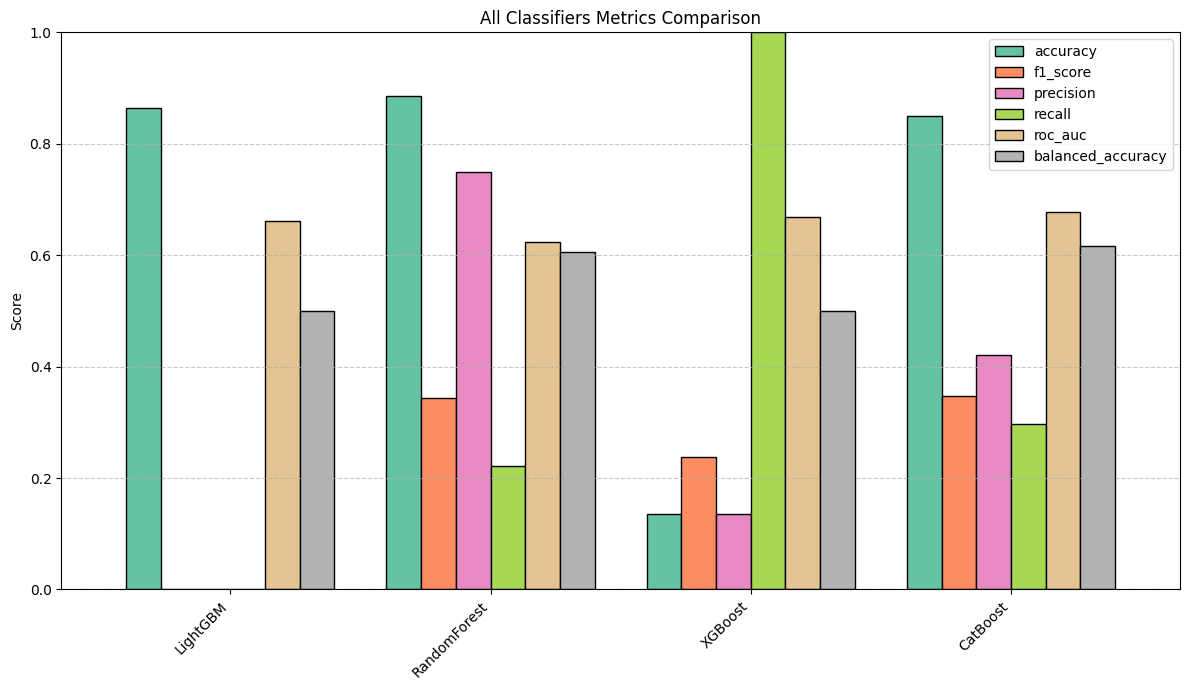

In [110]:
metrics = [
    "accuracy",
    "f1_score",
    "precision",
    "recall",
    "roc_auc",
    "balanced_accuracy",
]

fig, ax = plt.subplots(figsize=(12, 7))
df_results[metrics].plot(
    kind="bar", ax=ax, colormap="Set2", width=0.8, edgecolor="black"
)

ax.set_title("All Classifiers Metrics Comparison")
ax.set_ylabel("Score")

ax.set_ylim(0, 1)
ax.legend(loc="upper right")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
